### This notebook creates a .yaml "driver" file used in the monte_carlo setup 

This notebook uses values in an oil_capacity.xlsx spreadsheet. 

**To do**: 
- tighten-up values [in process]
- fix atb capacity weights so they sum to 1
- Update barge and ATB min/max fuel values to come from .xlsx spreadsheet rather than being hard-coded
- Make sure all the values we need for this notebook are in oil_capacity.xlsx (From cargo and fuel capacity values and references are in [this google spreadsheet](https://docs.google.com/spreadsheets/d/1URKN77iQHN-2cAVfG5T7SEiDTLTcolqL/edit#gid=1024416588))

In [1]:
import sys
import yaml
import pathlib
import numpy
import pandas
import matplotlib.pyplot as plt
import os
import warnings
from monte_carlo_utils import make_bins, get_bin, place_into_bins, decimal_divide

### Create Dictionary Structure

In [2]:

#~~~ Define the location for the yaml file created by this notebook ~~~~~~~~~
# I define this separately from other directories b/c it's just for 
# internal use within this notebook

output_directory = pathlib.Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
)
output_file = output_directory / 'oil_attribution.yaml'


#~~~ create dictionary structure ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
oil_attrs = {}

# create a section for directories and filenames
oil_attrs['directories'] = {}
oil_attrs['directories']['data'] = pathlib.Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
)
oil_attrs['directories']['geotiff'] = pathlib.Path(
    '/Users/rmueller/Data/MIDOSS/AIS/ShipTrackDensityGeoTIFFs/'
)

oil_attrs['files'] = {} 
# yaml files with Dept. of Ecology oil transfer data 
# US_origin is for US as origin 
# US_all represents the combined import and export of fuel

# to support smaller line lenghts!
ddir = oil_attrs['directories']['data']
# to save to file
oil_attrs['directories']['data'] = os.fspath(oil_attrs['directories']['data'])
oil_attrs['directories']['geotiff'] = os.fspath(oil_attrs['directories']['geotiff'])
# now to define other paths
oil_attrs['files']['CAD_origin']     = os.fspath(ddir/'CAD_origin.yaml')
oil_attrs['files']['WA_destination'] = os.fspath(ddir/'WA_destination.yaml')
oil_attrs['files']['WA_origin']      = os.fspath(ddir/'WA_origin.yaml')
oil_attrs['files']['US_origin']      = os.fspath(ddir/'US_origin.yaml')
oil_attrs['files']['US_combined']    = os.fspath(ddir/'US_all.yaml')
oil_attrs['files']['Pacific_origin'] = os.fspath(ddir/'Pacific_origin.yaml')
oil_attrs['files']['fuel']           = os.fspath(ddir/'fuel_by_vessel.yaml')

# excel spreadsheet with oil capacity data for all vessel types
oil_attrs['files']['oil_capacity']   = os.fspath(ddir/'oil_capacity.xlsx')

# weights for allocating tank barge capacities for ATBs < 50 m and tank barges 
oil_attrs['files']['barge_weights']  = os.fspath(ddir/'barge_capacity.yaml')

#~~~ Model setup categories ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# create a section for general categories 
oil_attrs['categories'] = {}

# labels for AIS ship traffic groups
oil_attrs['categories']['all_vessels'] = [
    'tanker', 
    'atb', 
    'barge', 
    'cargo', 
    'cruise',
    'ferry', 
    'fishing', 
    'smallpass', 
    'other'
]

# labels for oil tank traffic identified in AIS
oil_attrs['categories']['tank_vessels'] = [
    'tanker', 
    'atb', 
    'barge'
]

# tanker size classes (still in considerations)
oil_attrs['categories']['tanker_size_classes'] = [
    "Small Tanker (< 150 m)", 
    "Handymax (151-200 m)", 
    "Aframax (201-250 m)", 
    "SuezMax (251-300 m)" 
]

# fuel types used in categorizing Dept. of Ecology data and 
# for which we have Lagrangian files (with the exception of 'other')
oil_attrs['categories']['fuel_type']    = [
    'akns', 
    'bunker', 
    'dilbit', 
    'jet', 
    'diesel', 
    'gas', 
    'other'
]

# labels given to ship tracks in our AIS origin-destination analysis
# but that lack an origin or destination in our marine terminal list
# because (a) It's a part of a voyage < 2 km, (b) It's part of a voyage
# > 2 km but with a start or end that isn't connected to marine terminal
oil_attrs['categories']['generic_origin_destination'] = [
    'Pacific',
    'US',
    'Canada'
]
oil_attrs['categories']['CAD_origin_destination'] = [
    'ESSO Nanaimo Departure Bay',
    'Suncor Nanaimo',
    'Shell Chemainus Bare Point',
    'Chevron Cobble Hill',
    'Chevron Stanovan',
    'Barge Mooring Near Stanovan',
    'Shell Shellburn',
    'Westridge Marine Terminal',
    'ESSO IOCO Vancouver',
    'Suncor Vancouver'
]
oil_attrs['categories']['US_origin_destination'] = [ 
    'BP Cherry Point Refinery', 
    'Shell Puget Sound Refinery', 
    'Shell Oil LP Seattle Distribution Terminal',
    'Maxum (Rainer Petroleum)', 
    'Tidewater Snake River Terminal',
    'Nustar Energy Tacoma', 
    'SeaPort Sound Terminal', 
    'Tesoro Vancouver Terminal',
    'Phillips 66 Ferndale Refinery', 
    'Phillips 66 Tacoma Terminal', 
    'Andeavor Anacortes Refinery (formerly Tesoro)',
    'Tesoro Port Angeles Terminal',
    'U.S. Oil & Refining',
    'Naval Air Station Whidbey Island (NASWI)',
    'NAVSUP Manchester', 
    'Alon Asphalt Company (Paramount Petroleum)', 
    'Kinder Morgan Liquids Terminal - Harbor Island', 
    'Tesoro Pasco Terminal', 
    'REG Grays Harbor, LLC', 
    'Tidewater Vancouver Terminal',
    'TLP Management Services LLC (TMS)']

# ~~~ Create dictionary structure for vessel attributes  ~~~~~~~~~~~~~~~~~~~~

# create sections organized by vessel type
oil_attrs['vessel_attributes'] = {}

for vessels in oil_attrs['categories']['all_vessels']:
    oil_attrs['vessel_attributes'][vessels] = {}

### Load Oil Capacity Data and Attribute Vessels

/Users/rmueller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:249: RuntimeWarning: invalid value encountered in multiply


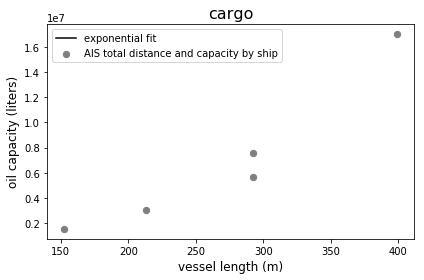

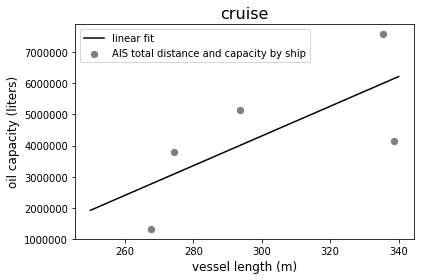

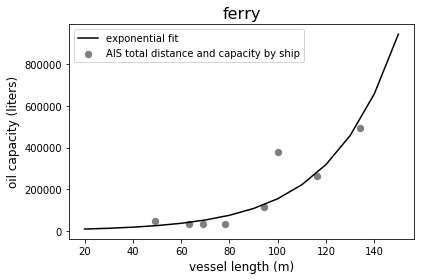

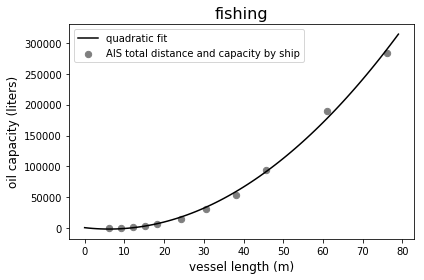

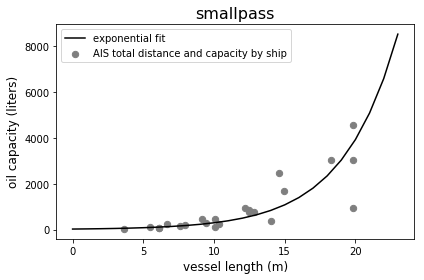

In [3]:
#~~~ tanker traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tanker_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='tanker', 
    usecols='B,C,D,E,F,G,H',
    headers=0
)

oil_attrs['vessel_attributes']['tanker']['tanker_types'] = (
    oil_attrs['categories']['tanker_size_classes']
)

# fuel parameters
oil_attrs['vessel_attributes']['tanker']['fuel_hfo_to_diesel'] = (
    tanker_df['hfo fuel capacity (liters)'].values.flatten()/
    tanker_df['diesel fuel capacity (liters)'].values.flatten()
).tolist()

oil_attrs['vessel_attributes']['tanker']['fuel_capacity'] = (
    tanker_df['total fuel capacity (liters)'].values.flatten() 
).tolist()

# cargo parameters
oil_attrs['vessel_attributes']['tanker']['cargo_capacity'] = (
    tanker_df['cargo capacity (liters)'].values.flatten() 
).tolist()

# These are the lengths of the vessels in the above website that correspond
# to the fuel ratios  and fuel capacities listed above
oil_attrs['vessel_attributes']['tanker']['vessel_lengths'] = (
    tanker_df['Silo ship size (m)'].values.flatten()
).tolist()

# create  bins for tanker categories
# Note: get_bin requires that adjacent bins share values, e.g.:
# [(0,150)(150,250)(250,300)]
# The sets are treated as: (0,150],(150,250], and (250,300]
bins = []
center_points = []
for index in range(len(tanker_df['min length (m)']-1)):
    bins.append(
        (tanker_df['min length (m)'][index].tolist(), 
         tanker_df['max length (m)'][index].tolist()+1)
    )
    step_size = (
        tanker_df['max length (m)'][index].tolist() - 
        tanker_df['min length (m)'][index].tolist()
    )
    center_points.append(tanker_df['min length (m)'][index] + step_size/2)

oil_attrs['vessel_attributes']['tanker']['length_bins'] = tuple(map(tuple, bins))

#~~~ atb traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# fuel and cargo capacity information
# K: "Vessel length (AIS)"
# L: "Vessel Length (AIS + <50 m correction)"
# O: "Total Fuel Capacity (liters)"
# P: "Cargo Capacity (liters)"

atb_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='atb', 
    usecols='K,L,O,P'
)

# AIS information
# B: COUNT, 
# C: LENGTH, 
# D: Median time
atb_data_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='atb data', 
    usecols='B,C,D'
)

# create line fit for atbs with length > 50 m
# fit = coefficient[1] + coefficient[0] * length
good_values = atb_df['Vessel Length (AIS + <50 m correction)']>0
cargo_fit_coefs = numpy.polyfit(
    atb_df['Vessel Length (AIS + <50 m correction)'][good_values], 
    atb_df['Cargo Capacity (liters)'][good_values], 
    1
)
oil_attrs['vessel_attributes']['atb']['cargo_fit_coefs'] = (
    cargo_fit_coefs.tolist()
)

fuel_fit_coefs= numpy.polyfit(
    atb_df['Vessel Length (AIS + <50 m correction)'][good_values], 
    atb_df['Total Fuel Capacity (liters)'][good_values], 
    1
)

oil_attrs['vessel_attributes']['atb']['fuel_fit_coefs'] = (
    fuel_fit_coefs.tolist()
)

# create fuel and cargo capacity bins into which vessel traffic information 
# is sorted to determine oil capacity weights. 
[cargo_bins, cargo_bin_centers]  = make_bins(
    lower_bound =  4000000,
    upper_bound = 30000000,
    step_size   = 2000000
)

[fuel_bins, fuel_bin_centers]  = make_bins(
    lower_bound =  75000,
    upper_bound = 675000,
    step_size   =  25000
)

# we use the median time interval between AIS pings per MMSI vessel to scale
# the total AIS ship track count so that count isn't biased by ping interval.  
scaling_factor = ( atb_data_df['Median time between pings (minutes)'] / 
    numpy.median(atb_data_df['Median time between pings (minutes)'])
)
atb_scaled_count = (atb_data_df['COUNT'] * scaling_factor )


### cargo weights ###
# bin scaled count (above) by cargo capacity and sum AIS count for each 
# cargo capacity bin to create cargo capacity weights
binned_atb_count_cargo = place_into_bins(
    atb_df['Cargo Capacity (liters)'], 
    atb_scaled_count, 
    cargo_bins
)

# use Decimal to work around binary arithmetic error
# such that weights sum to 1
precision = 10
numerator = binned_atb_count_cargo
denominator = binned_atb_count_cargo.sum()

cargo_weights = decimal_divide(
    numerator,
    denominator,
    precision
)
    
# define weighting for oil capacity attribution for atbs < 50 m   
oil_attrs['vessel_attributes']['atb']['cargo_capacity_probability'] = (
    cargo_weights.tolist()
)
oil_attrs['vessel_attributes']['atb']['cargo_capacity_bin_centers'] = (
    cargo_bin_centers
)
oil_attrs['vessel_attributes']['atb']['cargo_capacity_bins'] = (
    cargo_bins
)

### fuel weights ### 
# bin distance travelled by fuel capacity and sum distances for each 
# fuel capacity bin to create fuel capacity weights
binned_atb_count_by_fuel = place_into_bins(
    atb_df['Total Fuel Capacity (liters)'], 
    atb_scaled_count, 
    fuel_bins
)

# use Decimal to work around binary arithmetic error
# such that weights sum to 1
precision = 10
numerator = binned_atb_count_by_fuel
denominator = binned_atb_count_by_fuel.sum()

fuel_weights = decimal_divide(
    numerator,
    denominator,
    precision
)

oil_attrs['vessel_attributes']['atb']['fuel_capacity_probability']  = (
    fuel_weights.tolist()
)
oil_attrs['vessel_attributes']['atb']['fuel_capacity_bin_centers']  = (
    fuel_bin_centers
)
oil_attrs['vessel_attributes']['atb']['fuel_capacity_bins'] = (
    fuel_bins
)

#~~~ barge traffic (set to ATB) ~~~
# We use ATB traffic to determine barge weights b/c the number of ATB 
# vessels is manageable and has tugs paired with tank barges
oil_attrs['vessel_attributes']['barge']['cargo_capacity_probability'] = (
    cargo_weights.tolist()
)
oil_attrs['vessel_attributes']['barge']['cargo_capacity_bin_centers'] = (
    cargo_bin_centers
)
oil_attrs['vessel_attributes']['barge']['cargo_capacity_bins']        = (
    cargo_bins
)
oil_attrs['vessel_attributes']['barge']['fuel_capacity_probability']  = (
    fuel_weights.tolist()
)
oil_attrs['vessel_attributes']['barge']['fuel_capacity_bin_centers']  = (
    fuel_bin_centers
)
oil_attrs['vessel_attributes']['barge']['fuel_capacity_bins']         = (
    fuel_bins
)

#~~~ cargo traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cargo_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='cargo', 
    usecols='B,D,I,J'
)

min_length = cargo_df['AIS min length'][0]
max_length = cargo_df['AIS max length'][0]
length = cargo_df['vessel length (m)']
capacity = cargo_df['fuel capacity (liters)']
vessel_type = 'cargo'

container_fit_coefs= numpy.polyfit(
    length, 
    numpy.log(capacity), 
    1
)

oil_attrs['vessel_attributes']['cargo']['fuel_fit_coefs'] = (
    container_fit_coefs.tolist()
)

cargo_length = numpy.arange(150, 400, 10)
C = cargo_fit_coefs
cargo_fit = (
    numpy.exp(C[1]) * 
    numpy.exp(C[0]*cargo_length)
)

fig = plt.figure()
ax1 = fig.add_subplot(111)

# add ais-curated frequency data 
good_data = length>0
ax1.scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='AIS total distance and capacity by ship',
    color='tab:grey'
)

ax1.plot(cargo_length, cargo_fit, c='black', label='exponential fit')
plt.xlabel('vessel length (m)',fontsize=12)
plt.ylabel('oil capacity (liters)',fontsize=12)
plt.title(vessel_type, fontsize=16)
plt.tight_layout()
ax1.legend()
plt.show()

#~~~ cruise traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cruise_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='cruise', 
    usecols='B,D,I,J'
)

min_length = cruise_df['AIS min length'][0]
max_length = cruise_df['AIS max length'][0]
length = cruise_df['vessel length (m)']
capacity = cruise_df['fuel capacity (liters)']
vessel_type = 'cruise'

cruise_fit_coefs= numpy.polyfit(
    length, 
    capacity, 
    1
)

oil_attrs['vessel_attributes']['cruise']['fuel_fit_coefs'] = (
    cruise_fit_coefs.tolist()
)

cruise_length = numpy.arange(250, 350, 10)
C = cruise_fit_coefs
cruise_fit = (
    C[1] +
    C[0]*cruise_length
)

fig = plt.figure()
ax1 = fig.add_subplot(111)

# add ais-curated frequency data 
good_data = length>0
ax1.scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='AIS total distance and capacity by ship',
    color='tab:grey'
)
ax1.plot(cruise_length,cruise_fit, c='black', label='linear fit')

plt.xlabel('vessel length (m)',fontsize=12)
plt.ylabel('oil capacity (liters)',fontsize=12)
plt.title(vessel_type, fontsize=16)
plt.tight_layout()
ax1.legend()
plt.show()

#~~~ ferry traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ferry_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='ferry', 
    usecols='B,D,I,J'
)

min_length = ferry_df['AIS min length'][0]
max_length = ferry_df['AIS max length'][0]
length = ferry_df['vessel length (m)']
capacity = ferry_df['fuel capacity (liters)']
vessel_type = 'ferry'

ferry_fit_coefs= numpy.polyfit(
    length, 
    numpy.log(capacity), 
    1
)

oil_attrs['vessel_attributes']['ferry']['fuel_fit_coefs'] = (
    ferry_fit_coefs.tolist()
)

ferry_length = numpy.arange(20,160,10)

C = ferry_fit_coefs
ferry_fit = (
    numpy.exp(C[1])* 
    numpy.exp(C[0]*ferry_length)
)

fig = plt.figure()
ax1 = fig.add_subplot(111)

# add ais-curated frequency data 
good_data = length>0
ax1.scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='AIS total distance and capacity by ship',
    color='tab:grey'
)
ax1.plot(ferry_length,ferry_fit, c='black', label='exponential fit')
plt.xlabel('vessel length (m)',fontsize=12)
plt.ylabel('oil capacity (liters)',fontsize=12)
plt.title(vessel_type, fontsize=16)
plt.tight_layout()
ax1.legend()
plt.show()

#~~~ fishing traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fishing_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='fishing', 
    usecols='A,C,I,J'
)

length = fishing_df['vessel length (m)']
capacity = fishing_df['fuel capacity (liters)']
vessel_type = 'fishing'

fishing_exp_coefs= numpy.polyfit(
    length, 
    numpy.log(capacity), 
    1
)

fishing_length = numpy.arange(0, 80, 1)
Cexp = fishing_exp_coefs
fishing_exp_fit = (
    numpy.exp(Cexp[1])*
    numpy.exp(Cexp[0]*fishing_length)
)

fishing_fit_coefs= numpy.polyfit(
    length, 
    capacity, 
    2
)
oil_attrs['vessel_attributes']['fishing']['fuel_fit_coefs'] = (
    fishing_fit_coefs.tolist()
)

C = fishing_fit_coefs
fishing_fit = (
    C[2]+
    C[1]*fishing_length+
    C[0]*fishing_length**2
)

fig = plt.figure()
ax1 = fig.add_subplot(111)

# add ais-curated frequency data 
good_data = length>0
ax1.scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='AIS total distance and capacity by ship',
    color='tab:grey'
)
ax1.plot(fishing_length,fishing_fit, c='black', label='quadratic fit')

#labels, etc.
plt.xlabel('vessel length (m)',fontsize=12)
plt.ylabel('oil capacity (liters)',fontsize=12)
plt.title(vessel_type, fontsize=16)
plt.tight_layout()
ax1.legend()
plt.show()

#~~~ small passenger traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

smallpass_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='smallpass', 
    usecols='B,D'
)

length = smallpass_df['vessel length (m)']
capacity = smallpass_df['fuel capacity (liters)']
vessel_type = 'smallpass'

smallpass_fit_coefs= numpy.polyfit(
    length, 
    numpy.log(capacity), 
    1
)

oil_attrs['vessel_attributes']['smallpass']['fuel_fit_coefs'] = (
    smallpass_fit_coefs.tolist()
)

smallpass_length = numpy.arange(0, 24, 1)
C = smallpass_fit_coefs
smallpass_fit = (
    numpy.exp(C[1])*
    numpy.exp(C[0]*smallpass_length)
)

fig = plt.figure()
ax1 = fig.add_subplot(111)

# add ais-curated frequency data 
good_data = length>0
ax1.scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='AIS total distance and capacity by ship',
    color='tab:grey'
)
ax1.plot(
    smallpass_length, 
    smallpass_fit, 
    c='black', 
    label='exponential fit'
)


#labels, etc.
plt.xlabel('vessel length (m)',fontsize=12)
plt.ylabel('oil capacity (liters)',fontsize=12)
plt.title(vessel_type, fontsize=16)
plt.tight_layout()
ax1.legend()
plt.show()

#~~~ other ~~~
## Use same data as small passenger
oil_attrs['vessel_attributes']['other']['fuel_fit_coefs'] = (
    smallpass_fit_coefs.tolist()
)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Set the probability of incident as fuel spill vs. cargo spill for 
#  oil-cargo vessels.  I use probability-of-cargo = 1-(probability-of-fuel) 
#  to ensure sum of 1. 
oil_attrs['vessel_attributes']['tanker']['probability_fuel']  = 0.2
oil_attrs['vessel_attributes']['tanker']['probability_cargo'] = 1 - \
oil_attrs['vessel_attributes']['tanker']['probability_fuel']

oil_attrs['vessel_attributes']['atb']['probability_fuel']  = 0.2
oil_attrs['vessel_attributes']['atb']['probability_cargo'] = 1 - \
oil_attrs['vessel_attributes']['atb']['probability_fuel']

oil_attrs['vessel_attributes']['barge']['probability_fuel']  = 0.2
oil_attrs['vessel_attributes']['barge']['probability_cargo'] = 1 - \
oil_attrs['vessel_attributes']['barge']['probability_fuel']

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Set the probability of a barge carrying oil-cargo for a ship track 
#  that is identified as barge but that lacks origin-destination information
# 57% of barge tracks were joined in the origin-destination analysis 
# (and will be attributed as having oil cargo), 2.1e6 tracks are estimated
# to be oil cargo tracks based on ATB traffic, 1.39e7 tracks represent all
# barge traffic. 
oil_attrs['vessel_attributes']['barge']['probability_oilcargo'] = (
    (1 - 0.57) * 2.1/13.9 
)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set minimum cargo capacities in liters
oil_attrs['vessel_attributes']['tanker']['min_cargo'] = 7593628  # small tanker size 
oil_attrs['vessel_attributes']['atb']['min_cargo']    = 4000000  # smallest load of known ATBs (Island Trader: oil_capacity.xlsx)
oil_attrs['vessel_attributes']['barge']['min_cargo']  = 1500000  # 1,589,900: 3A-10 of [DOE report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set maximum cargo capacities in liters
oil_attrs['vessel_attributes']['tanker']['max_cargo'] = 185447000 # Corresponding to tank capacity of Suez-Max tankers as AIS data shows tanker lengths up to 287 m
oil_attrs['vessel_attributes']['atb']['max_cargo']    =  29413150 # largest load of known ATBs (Kirby 185-01: oil_capacity.xlsx)
oil_attrs['vessel_attributes']['barge']['max_cargo']  =  32000000 # 31,797,444: 3A-10 of [DOE report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Set fuel size classes 
# Tankers: SuezMax (285 m), Aframax (245 m), Handymax (180 m), Small Tanker (116 m)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set minimum fuel capacities in liters
# PLACEHOLDER[Needs AIS verification]: Reflects small tanker in 
# https://silo.tips/download/suezmax-oil-tanker-tankers-166300-dwt
#
oil_attrs['vessel_attributes']['tanker']['min_fuel']    = (
    tanker_df['total fuel capacity (liters)'][0].tolist()
)
# End PLACEHOLDER
oil_attrs['vessel_attributes']['atb']['min_fuel']       = 99000   # Based on Island Raider and Island Regent tugs in Charles Costanzo's `ATB Information AWO Edits`
oil_attrs['vessel_attributes']['barge']['min_fuel']     = 6000    # 5678 (F43): Harbour Tug
oil_attrs['vessel_attributes']['cargo']['min_fuel']     = 1500000 # 1,514,164
oil_attrs['vessel_attributes']['cruise']['min_fuel']    = 1000000 
oil_attrs['vessel_attributes']['ferry']['min_fuel']     = 30000   # 34,068
oil_attrs['vessel_attributes']['fishing']['min_fuel']   = 150
oil_attrs['vessel_attributes']['smallpass']['min_fuel'] = 100
oil_attrs['vessel_attributes']['other']['min_fuel']     = 100   # 22 (F52)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set maximum fuel capacities in liters (to be filled in )
# NOTE: Max volume for ferries reflects WA ferries.  See "Other Ship Classifications"
# and Living Oceans information with reference to [BC ferries doc](http://ferriesbc.proboards.com/thread/7592/fueling-bcs-ferries)
oil_attrs['vessel_attributes']['tanker']['max_fuel']    = tanker_df['total fuel capacity (liters)'][3].tolist()
# NOTE: Ocean-going tank barge listed as 52,995,000 liters max fuel capacity 
# accoring to [NOAA](https://response.restoration.noaa.gov/about/media/how-much-oil-ship.html)
oil_attrs['vessel_attributes']['atb']['max_fuel']       = 550000    # Again, based on Dublin Sea Charles Costanzo's 
oil_attrs['vessel_attributes']['barge']['max_fuel']     = 710000    # 700,300: Ocean Tug (need to verify that we have them in S.S.)
oil_attrs['vessel_attributes']['cargo']['max_fuel']     = 2000000  # 1,7034,345
oil_attrs['vessel_attributes']['cruise']['max_fuel']    = 5500000   # 5,149,456
oil_attrs['vessel_attributes']['ferry']['max_fuel']     = 500000    # 492,103. 
oil_attrs['vessel_attributes']['fishing']['max_fuel']   = 300000    # 283,906  (see p. 3A-6 of [DOE report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf))
oil_attrs['vessel_attributes']['smallpass']['max_fuel'] = 12000     # 11356 (F41)
oil_attrs['vessel_attributes']['other']['max_fuel']     = 12000      # 3,028 (F77): Cruising, sport fishing, sailing

# if driver['tank_fuel_probability'] + driver['tank_cargo_probability'] != 1:
#     sys.error('fuel vs. cargo probability needs is not adding to 1')

with open(output_file, 'w') as file:
    documents = yaml.dump(oil_attrs, file)

In [16]:
fuel_weights.sum()

Decimal('1.000000000')

### Graphics

In [4]:
## placeholder for tanker cargo capacity bins

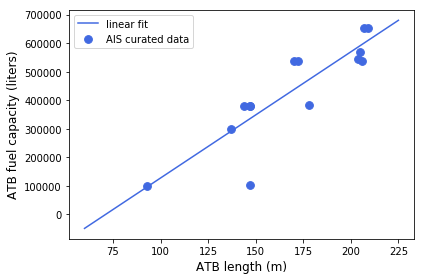

In [5]:
#~~~~ ATB (> 50 m) fuel capacity line fit ~~~~
C = oil_attrs['vessel_attributes']['atb']['fuel_fit_coefs']
test_length = numpy.arange(60,230,5)
test_atb_fit = ( 
    C[1] + 
    C[0]*test_length 
)

atbfig = plt.figure()
ax1 = atbfig.add_subplot(111)
ax1.scatter(
    atb_df['Vessel Length (AIS + <50 m correction)'][good_values],
    atb_df['Total Fuel Capacity (liters)'][good_values],
    60,
    label='AIS curated data',
    color='royalblue'
)
ax1.plot(test_length, test_atb_fit, c='royalblue', label='linear fit')
plt.xlabel('ATB length (m)',fontsize=12)
plt.ylabel('ATB fuel capacity (liters)',fontsize=12)
plt.tight_layout()
ax1.legend()
#plt.savefig('ATB_cargo_ais.png')
plt.show()

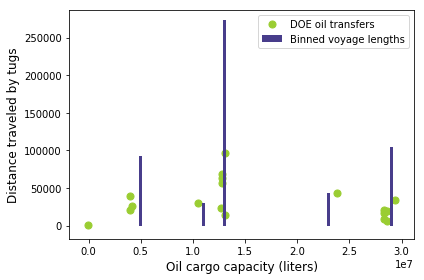

In [6]:
#~~~~ ATB (< 50 m) and tank barge cargo capacity weighting ~~~~
fig = plt.figure()
ax2 = fig.add_subplot(111)

# add binned-ship-track frequencies
ax2.bar(
    cargo_bin_centers,
    binned_atb_count_cargo,
    width=0.3e6,
    label='Binned voyage lengths',
    color='darkslateblue'
)

# add ais-curated frequency data 
ax2.scatter(
    atb_df['Cargo Capacity (liters)'][0:18],
    atb_data_df['COUNT'],
    50,
    label='DOE oil transfers',
    color='yellowgreen'
)

#labels, etc.
plt.xlabel('Oil cargo capacity (liters)',fontsize=12)
plt.ylabel('Distance traveled by tugs',fontsize=12)
plt.tight_layout()
ax2.legend()
#plt.savefig('tank_barge_distance_binnedbycapacity.png')
plt.show() 

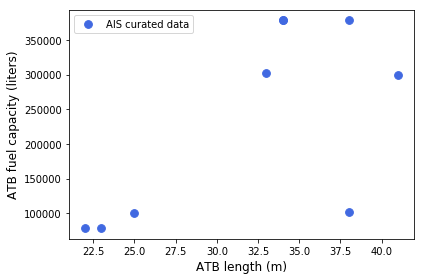

In [7]:
small = atb_df['Vessel length (AIS)']<50
atbfig = plt.figure()
ax1 = atbfig.add_subplot(111)
ax1.scatter(
    atb_df['Vessel length (AIS)'][small],
    atb_df['Total Fuel Capacity (liters)'][small],
    60,
    label='AIS curated data',
    color='royalblue'
)
#ax1.plot(test_length, test_atb_fit, c='royalblue', label='linear fit')
plt.xlabel('ATB length (m)',fontsize=12)
plt.ylabel('ATB fuel capacity (liters)',fontsize=12)
plt.tight_layout()
ax1.legend()
#plt.savefig('ATB_cargo_ais.png')
plt.show()

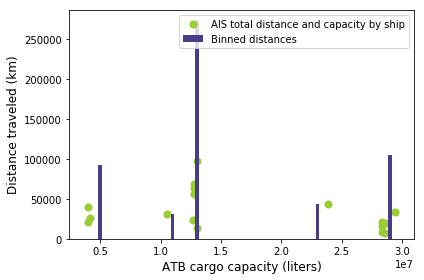

In [8]:
#~~~~ plot  ais pings by vessel lengths  and ais pings by binned lengths, for comparison~~~~
aisfig = plt.figure()
ax1 = aisfig.add_subplot(111)


# add binned-ship-track frequencies
ax1.bar(
    cargo_bin_centers,
    binned_atb_count_cargo,
    width=0.3e6,
    label='Binned distances',
    color='darkslateblue'
)

# add ais-curated frequency data 
good_data = atb_df['Cargo Capacity (liters)']>0
ax1.scatter(
    atb_df['Cargo Capacity (liters)'][good_data],
    atb_data_df['COUNT'][good_data],
    50,
    label='AIS total distance and capacity by ship',
    color='yellowgreen'
)

#labels, etc.
plt.xlabel('ATB cargo capacity (liters)',fontsize=12)
plt.ylabel('Distance traveled (km)',fontsize=12)
plt.tight_layout()
ax1.legend()
#plt.savefig('ATB_frequency_ais.png')
plt.show() 

In [9]:
oil_attrs['vessel_attributes']['tanker']

{'tanker_types': ['Small Tanker (< 150 m)',
  'Handymax (151-200 m)',
  'Aframax (201-250 m)',
  'SuezMax (251-300 m)'],
 'fuel_hfo_to_diesel': [12.793296089385475,
  14.046153846153846,
  17.419753086419753,
  30.96153846153846],
 'fuel_capacity': [740700, 1956000, 2984000, 4155000],
 'cargo_capacity': [7748600, 53000000, 126211000, 185447000],
 'vessel_lengths': [108.5, 182.0, 247.24, 281.0],
 'length_bins': ((0, 151), (151, 201), (201, 251), (251, 301)),
 'probability_fuel': 0.2,
 'probability_cargo': 0.8,
 'min_cargo': 7593628,
 'max_cargo': 185447000,
 'min_fuel': 740700,
 'max_fuel': 4155000}

In [10]:
oil_attrs['vessel_attributes']['tanker']['length_bins']

((0, 151), (151, 201), (201, 251), (251, 301))

In [11]:
oil_attrs['vessel_attributes']['atb']['fuel_capacity_bins']

[(75000, 100000),
 (100000, 125000),
 (125000, 150000),
 (150000, 175000),
 (175000, 200000),
 (200000, 225000),
 (225000, 250000),
 (250000, 275000),
 (275000, 300000),
 (300000, 325000),
 (325000, 350000),
 (350000, 375000),
 (375000, 400000),
 (400000, 425000),
 (425000, 450000),
 (450000, 475000),
 (475000, 500000),
 (500000, 525000),
 (525000, 550000),
 (550000, 575000),
 (575000, 600000),
 (600000, 625000),
 (625000, 650000),
 (650000, 675000)]

In [12]:
bins = []
center_points = []
for index in range(len(tanker_df['min length (m)']-1)):
    bins.append(
        (tanker_df['min length (m)'][index].tolist(), 
         tanker_df['max length (m)'][index].tolist()+1)
    )
    step_size = (
        tanker_df['max length (m)'][index].tolist() - 
        tanker_df['min length (m)'][index].tolist()
    )
    center_points.append(tanker_df['min length (m)'][index] + step_size/2)



In [13]:
bins

[(0, 151), (151, 201), (201, 251), (251, 301)]

In [14]:
tanker_df['min length (m)'].tolist()

[0, 151, 201, 251]

In [15]:
test

NameError: name 'test' is not defined